# 17기 KNN 정규세션 과제

## KNN 구현해보기
### 1. Preprocssing / EDA
지금까지 배운 내용을 토대로 해당 데이터에 대해 자유롭게 전처리와 EDA를 진행해주세요.
### 2. KNN 구현 & 파라미터 튜닝
수업 내용 및 실습 자료를 참고하여 KNN을 구현하고 파라미터 튜닝을 하며 결과를 비교해주세요.
### 3. Evaluation
결과에 대한 평가를 진행하고, 나름의 해석을 달아주세요.

**데이터:** [blackfriday | Kaggle](https://www.kaggle.com/llopesolivei/blackfriday)

---

## 0. 모듈 불러오기

In [24]:
# 데이터 전처리
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# 기계학습 모델 및 평가
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor, DistanceMetric, NearestNeighbors
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.model_selection import KFold

from tqdm import tqdm_notebook
from tqdm import tqdm
from scipy.stats import spearmanr
from collections import Counter


# 시각화
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib
from matplotlib.colors import ListedColormap
matplotlib.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings('ignore')

## 1. 데이터 불러오기

In [2]:
import pandas as pd
df = pd.read_csv("blackfriday.csv", index_col = 0)
df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1001088,P00046042,F,0-17,10,A,3,0,5,17.0,NaN,2010
1,1004493,P00347742,F,0-17,10,A,1,0,7,NaN,NaN,4483
2,1005302,P00048942,F,0-17,10,A,1,0,1,4.0,NaN,7696
3,1001348,P00145242,F,0-17,10,A,3,0,2,4.0,NaN,16429
4,1001348,P00106742,F,0-17,10,A,3,0,3,5.0,NaN,5780


## 2. 데이터 탐색

### Preprocessing & EDA

In [3]:
df.shape

(4998, 12)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4998 entries, 0 to 4997
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   User_ID                     4998 non-null   int64  
 1   Product_ID                  4998 non-null   object 
 2   Gender                      4998 non-null   object 
 3   Age                         4998 non-null   object 
 4   Occupation                  4998 non-null   int64  
 5   City_Category               4998 non-null   object 
 6   Stay_In_Current_City_Years  4998 non-null   object 
 7   Marital_Status              4998 non-null   int64  
 8   Product_Category_1          4998 non-null   int64  
 9   Product_Category_2          3465 non-null   float64
 10  Product_Category_3          1544 non-null   float64
 11  Purchase                    4998 non-null   int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 507.6+ KB


In [5]:
for i in df.columns : 
    print(df[i].value_counts())
    print('*' * 50)

1002063    12
1005795    12
1001980    11
1004344    11
1006036    10
           ..
1004980     1
1004385     1
1004138     1
1002648     1
1000837     1
Name: User_ID, Length: 2656, dtype: int64
**************************************************
P00265242    21
P00220442    16
P00114942    15
P00010742    15
P00148642    15
             ..
P00072342     1
P00037842     1
P00207042     1
P00129742     1
P00358242     1
Name: Product_ID, Length: 1797, dtype: int64
**************************************************
M    3765
F    1233
Name: Gender, dtype: int64
**************************************************
26-35    1996
36-45    1000
18-25     906
46-50     414
51-55     350
55+       195
0-17      137
Name: Age, dtype: int64
**************************************************
4     706
0     572
7     535
1     460
17    339
12    305
20    285
2     251
14    245
16    244
6     186
3     160
15    133
10    122
5      98
11     95
19     73
13     65
18     56
9      50
8      18


* 12개의 column으로 구성된 4,998개의 고객 신상 데이터이며, `Purchase`를 Target으로 설정함. (= KNN Regression)

**Target**
    
   * `purchase` : 구매량, Numerical
    

**설명변수**
    
   * `User_ID` : 고객 ID, Categorical
    
   * `Product_ID` : 제품 ID, Categorical
    
   * `Gender` : 성별, Categorical
    
   * `Age` : 나이대, Categorical
    
   * `Occupation` : 직업, Categorical
    
   * `City_Category` : 도시 분류, Categorical
    
   * `Stay_In_Current_City_Years` : 현재 도시에 거주한 년수, Categorical
    
   * `Marital_Status` : 결혼 여부, Categorical(0 : Single / 1 : Married)
    
   * `Product_Category_1`, `Product_Category_2`, `Product_Category_3` : 제품 분류 1,2,3 , Categorical

In [6]:
df.isnull().sum()

User_ID                          0
Product_ID                       0
Gender                           0
Age                              0
Occupation                       0
City_Category                    0
Stay_In_Current_City_Years       0
Marital_Status                   0
Product_Category_1               0
Product_Category_2            1533
Product_Category_3            3454
Purchase                         0
dtype: int64

* `Product_Category_3`의 결측치는 3,454개로, 결측치가 전체 데이터의 약 70%를 차지함. 따라서 결측치를 채우는 과정에 왜곡이 발생할 수 있으므로 해당 Column은 drop함.

* `Product_Category_2`는 Simple Imputer로 결측치를 채워줌.

In [7]:
from sklearn.impute import SimpleImputer

In [8]:
imputer = SimpleImputer(strategy='most_frequent')

In [9]:
df[['Product_Category_2']] = imputer.fit_transform(df[['Product_Category_2']])

In [10]:
df.drop(['Product_Category_3'], axis=1, inplace=True)

In [11]:
# 결측치 처리 확인
df.isnull().sum()

User_ID                       0
Product_ID                    0
Gender                        0
Age                           0
Occupation                    0
City_Category                 0
Stay_In_Current_City_Years    0
Marital_Status                0
Product_Category_1            0
Product_Category_2            0
Purchase                      0
dtype: int64

결측치가 없음을 알 수 있음.

In [12]:
df.nunique()

User_ID                       2656
Product_ID                    1797
Gender                           2
Age                              7
Occupation                      21
City_Category                    3
Stay_In_Current_City_Years       5
Marital_Status                   2
Product_Category_1              20
Product_Category_2              17
Purchase                      3736
dtype: int64

* `User_ID`의 고유값이 전체 데이터 개수와 비교해 봤을 때 상당히 많기 때문에(2,656) 해당 Column을 포함하여 모델링을 진행하면 Overfitting이 될 가능성이 있기에 drop함.

In [13]:
df.drop(['User_ID'], axis=1, inplace=True)

In [14]:
df.head()

,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Purchase
0,P00046042,F,0-17,10,A,3,0,5,17.0,2010
1,P00347742,F,0-17,10,A,1,0,7,8.0,4483
2,P00048942,F,0-17,10,A,1,0,1,4.0,7696
3,P00145242,F,0-17,10,A,3,0,2,4.0,16429
4,P00106742,F,0-17,10,A,3,0,3,5.0,5780


### One-hot-encoding

KNN은 거리 기반 알고리즘이므로 input에 numerical이 와야 함. 따라서 categorical 변수들은 `One-hot-encoding`으로 1 또는 0으로 지정해줘야 함. 

(1) One-hot-encoding을 해야 하는 Categorical Features : `Product_ID`, `Gender`, `Age`, `Occupation`, `City_Category`, `Stay_In_Current_City_Years`, `Product_Category_1`, `Product_Category_2`

(2) `Product_ID`는 그룹 단위로 One-hot-encoding을 진행함.

In [15]:
# One-Hot-Encoding (1)

categorical = ['Gender', 'Age', 'Occupation', 'City_Category', 'Stay_In_Current_City_Years', 'Product_Category_1', 'Product_Category_2']

encoder1 = OneHotEncoder().fit(df[categorical])

In [16]:
# 제품 ID 앞 4자리를 기준으로 리스트 생성, 고유값 확인
product_id = []

for i in df.Product_ID.values:
    product_id.append(i[:4])
    
unique_product_id = list(set(product_id))
unique_product_id

['P002', 'P001', 'P000', 'P009', 'P003']

In [17]:
# 제품 ID 앞 4자리 기준으로 그룹화
P000_index = [i for i, value in enumerate(product_id) if value == 'P000']
P001_index = [i for i, value in enumerate(product_id) if value == 'P001']
P002_index = [i for i, value in enumerate(product_id) if value == 'P002']
P003_index = [i for i, value in enumerate(product_id) if value == 'P003']
P009_index = [i for i, value in enumerate(product_id) if value == 'P009']

In [18]:
# One-Hot-Encoding (2) - Product_ID Column
# 제품 ID 값을 각 제품 ID의 4번째 숫자로 대체 -> 그룹화

for i in P000_index:
    df.iloc[i, 0] = 0

for i in P001_index:
    df.iloc[i, 0] = 1
    
for i in P002_index:
    df.iloc[i, 0] = 2
    
for i in P003_index:
    df.iloc[i, 0] = 3
    
for i in P009_index:
    df.iloc[i, 0] = 9
    
encoder2 = OneHotEncoder().fit(df[['Product_ID']])

In [19]:
# 최종 DataFrame
encoded1 = pd.DataFrame(encoder1.transform(df[categorical]).toarray(), index=df.index, columns = encoder1.get_feature_names(categorical))

encoded2 = pd.DataFrame(encoder2.transform(df[['Product_ID']]).toarray(), index = df.index, columns = encoder2.get_feature_names(['Product_ID']))

df1 = pd.concat([df, encoded1], sort=False, axis=1)
df2 = pd.concat([df1, encoded2], sort=False, axis=1)

df = df2.drop(['Product_ID', 'Gender', 'Age', 'Occupation', 'City_Category', 'Stay_In_Current_City_Years', 'Product_Category_1', 'Product_Category_2'], axis=1)

df.head()

,Marital_Status,Purchase,Gender_F,Gender_M,Age_0-17,Age_18-25,Age_26-35,Age_36-45,Age_46-50,Age_51-55,...,Product_Category_2_14.0,Product_Category_2_15.0,Product_Category_2_16.0,Product_Category_2_17.0,Product_Category_2_18.0,Product_ID_0,Product_ID_1,Product_ID_2,Product_ID_3,Product_ID_9
0,0,2010,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0,4483,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0,7696,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0,16429,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0,5780,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


### 데이터 분리

In [20]:
X = df.drop(['Purchase'], axis=1)
y = df.Purchase

In [21]:
# Train set(70%) / Test set(30%) 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [22]:
print(X_train.shape)
print(X_test.shape)

(3498, 81)
(1500, 81)


* 전체 데이터 중 70%를 Train Data로, 나머지 30%를 Test Data로 분리함.
* 설명변수는 모두 Categorical이므로, Feature Scaling을 진행하지 않음.

## 3. 모델링

* K 개수 결정

* Distance measure 결정

### K에 따른 결과

* K가 매우 작을 경우 : 데이터의 지역적 특성을 지나치게 반영함(overfitting)

* K가 매우 클 경우 : 다른 범주의 개체를 너무 많이 포함하여 오분류할 위험이 있음 (underfitting)

### 4.1 Hyperparameter K 결정

* k는 1~100 사이의 홀수 값들로 임의로 지정함.

* Distance Measure은 가장 널리 쓰이는 Euclidean Distance를 기준으로 함.

In [25]:
k_list = [i for i in range(1, 100) if i%2 != 0]
train_accuracy = []
test_accuracy = []

for k in tqdm(k_list):
    reg = KNeighborsRegressor(n_neighbors=k, p=2)
    # p=1: manhattan_distance, p=2: euclidean_distance, # p=l_p: minkoski_distance
    reg.fit(X_train, y_train)
    # Train Data에 대한 결정계수
    train_accuracy.append(reg.score(X_train, y_train))
    # Test Data에 대한 결정계수
    test_accuracy.append(reg.score(X_test, y_test))

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.02it/s]


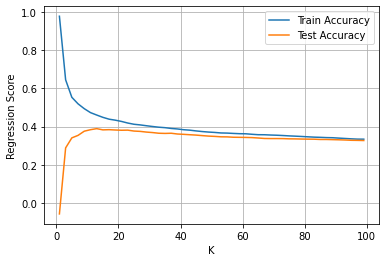

In [26]:
# K 변화에 따른 Accuracy 변화 시각화
plt.plot(k_list, train_accuracy, label='Train Accuracy')
plt.plot(k_list, test_accuracy, label='Test Accuracy')
plt.xlabel('K')
plt.ylabel('Regression Score')
plt.grid()
plt.legend()
plt.show()

* K가 커질수록 Train Accuracy는 떨어지고, Test Accuracy는 높아지는 경향이 있음.

* `train_accuracy`와 `test_accuracy`를 내림차순으로 정렬 후 상위 10개 값의 index와 교집합 원소를 추출함.

In [27]:
train_rank_10 = pd.Series(train_accuracy).sort_values(ascending=False).index[:10]
test_rank_10 = pd.Series(test_accuracy).sort_values(ascending=False).index[:10]

print(train_rank_10)
print('*' * 60)
print(test_rank_10)
print('*' * 60)
print(train_rank_10.intersection(test_rank_10))

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype='int64')
************************************************************
Int64Index([6, 8, 5, 7, 9, 11, 10, 12, 4, 13], dtype='int64')
************************************************************
Int64Index([4, 5, 6, 7, 8, 9], dtype='int64')


* `train_accuracy`와 `test_accuracy` 모두에서 상위 10개 안에 드는 K는 4,5,6,7,8,9임

#### 교차 검증으로 정확도 비교하기

In [28]:
k_list = [i for i in range(1,100) if i%2 != 0]
cv_scores = []

for k in tqdm_notebook(k_list):
    cv_reg = KNeighborsRegressor(n_neighbors=k, p=2)
    
    # 10-cross validation으로 탐색
    # scores: k값마다 10개의 값 누적
    scores = cross_val_score(cv_reg, X_train, y_train, cv=10)
    
    # scores의 평균을 k값 마다의 성능 평가 결과로 사용
    cv_scores.append(scores.mean())

  0%|          | 0/50 [00:00<?, ?it/s]

In [29]:
# scoring이 accuracy이므로 값이 높을수록 좋음
# cv_scores를 가장 높게 만든 k값을 best_k값으로 선정
best_k = [k_list[i] for i in range(len(cv_scores)) if cv_scores[i] == np.max(cv_scores)]
print('Best k values : ', best_k)

Best k values :  [17]


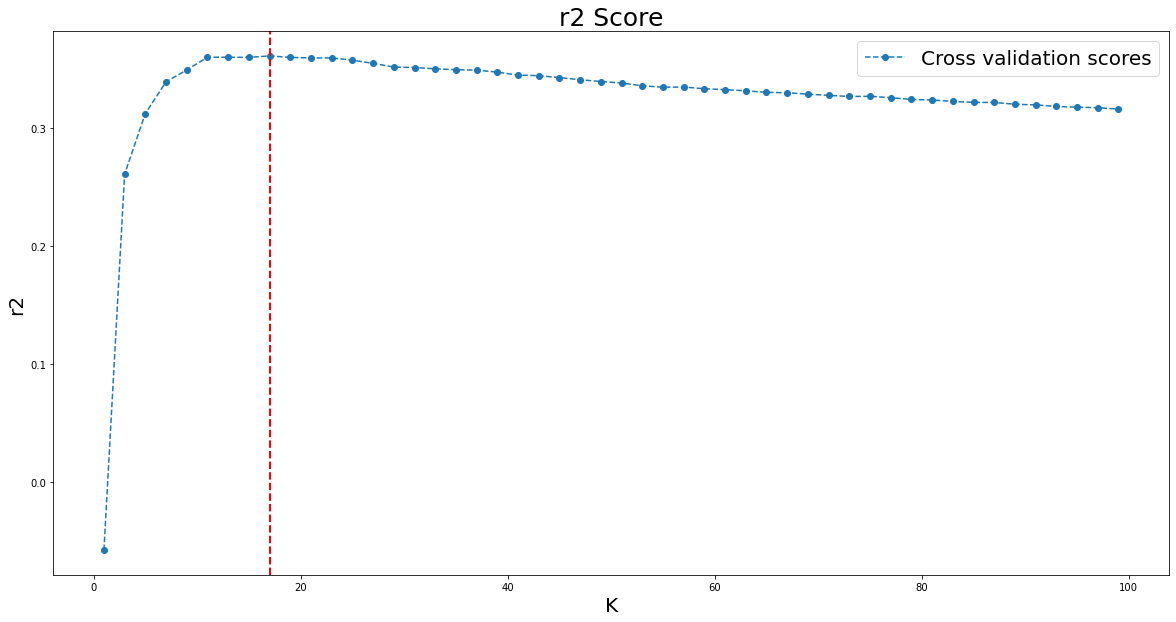

In [52]:
plt.figure(figsize=(20,10))
plt.plot(k_list, cv_scores, marker='o', linestyle='dashed')
plt.legend(['Cross validation scores'], fontsize=20)
plt.xlabel('K', fontsize=20)
plt.ylabel('r2', fontsize=20)
plt.title('r2 Score', fontsize=25)
plt.axvline(best_k[0], color='r', linestyle='--', linewidth=2)
plt.show()

* K가 17일 때 Accuracy가 가장 높음.

### 4.2 Distance type 결정

### 4.2.1 Euclidean Distance

* 가장 흔히 사용되는 거리측도
* 대응되는 x, y 값 간 차이 제곱합의 제곱근으로써, 두 관측치 사이의 직선 거리를 의미함.

$$ d_{(X,Y)}=\sqrt{\sum_{i=1}^n(x_i-y_i)^2}$$

In [45]:
k_list = [i for i in range(1,100) if i%2 != 0]

euc = []
for k in tqdm_notebook(k_list):
    cv_reg_euc = KNeighborsRegressor(n_neighbors=k, p=2)
    scores = cross_val_score(cv_reg_euc, X_train, y_train, cv=10, scoring='r2')
    euc.append(scores.mean())

  0%|          | 0/50 [00:00<?, ?it/s]

In [46]:
best_k_euc = [k_list[i] for i in range(len(euc)) if euc[i] == np.max(euc)]
print('Best k values : ', best_k_euc)

Best k values :  [17]


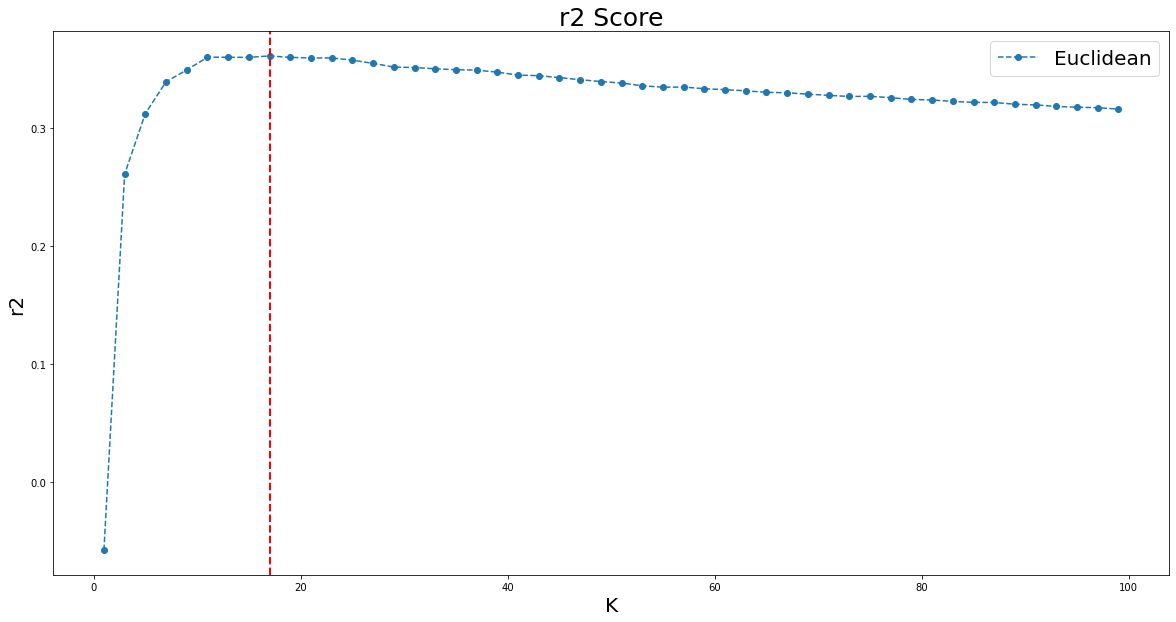

In [49]:
plt.figure(figsize=(20,10))
plt.plot(k_list, euc, marker='o', linestyle='dashed')
plt.legend(['Euclidean'], fontsize=20)
plt.xlabel('K', fontsize=20)
plt.ylabel('r2', fontsize=20)
plt.title('r2 Score', fontsize=25)
plt.axvline(best_k_euc[0], color='r', linestyle='--', linewidth=2)
plt.show()

### 4.2.2 Manhattan Distance

* x에서 y로 이동 시 각 좌표축 방향으로만 이동할 경우에 계산되는 거리

$$ d_{Manhattan(X,Y)}=\sum_{i=1}^n|x_i-y_i|$$

In [48]:
k_list = [i for i in range(1,100) if i%2 != 0]

man = []
for k in tqdm_notebook(k_list):
    cv_reg_man = KNeighborsRegressor(n_neighbors=k, p=1)
    scores = cross_val_score(cv_reg_man, X_train, y_train, cv=10, scoring='r2')
    man.append(scores.mean())

  0%|          | 0/50 [00:00<?, ?it/s]

In [50]:
best_k_man = [k_list[i] for i in range(len(man)) if man[i] == np.max(man)]
print('Best k values : ', best_k_man)

Best k values :  [17]


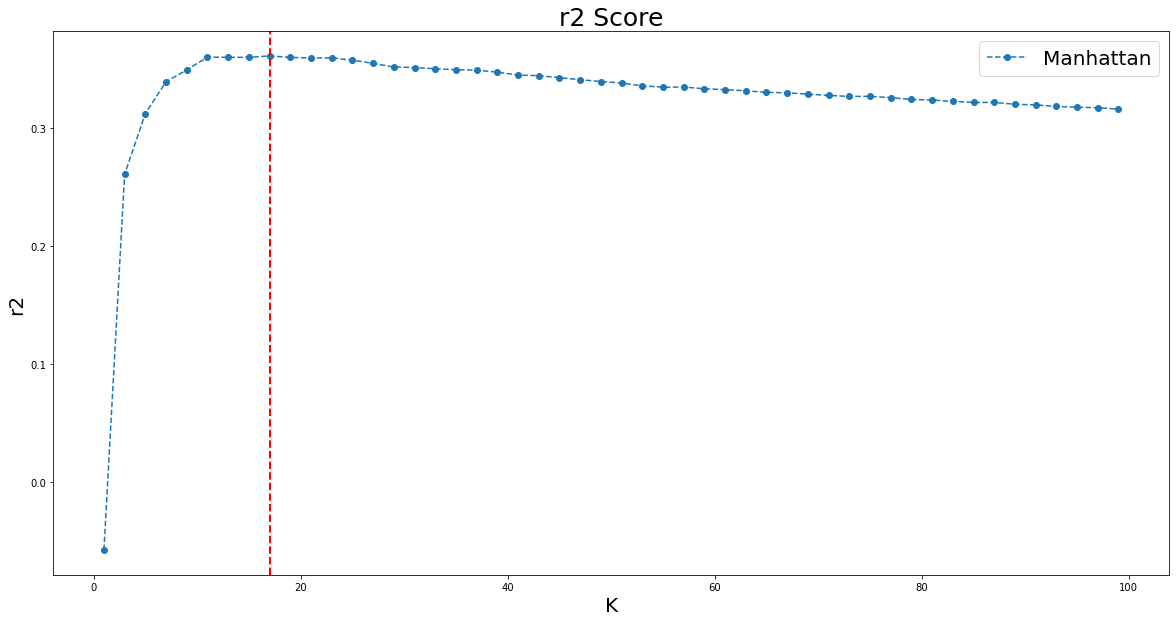

In [51]:
plt.figure(figsize=(20,10))
plt.plot(k_list, man, marker='o', linestyle='dashed')
plt.legend(['Manhattan'], fontsize=20)
plt.xlabel('K', fontsize=20)
plt.ylabel('r2', fontsize=20)
plt.title('r2 Score', fontsize=25)
plt.axvline(best_k_man[0], color='r', linestyle='--', linewidth=2)
plt.show()

### 4.2.3 Minkowski Distance

$$d(x,y) = [\sum_{i=1}^p|x_i-y_i|^m]^{1/m}$$

In [35]:
k_list = [i for i in range(1,100) if i%2 != 0]

kow = []
for k in tqdm_notebook(k_list):
    cv_reg_kow = KNeighborsRegressor(n_neighbors=k, p=3, metric='minkowski')
    scores = cross_val_score(cv_reg_kow, X_train, y_train, cv=10, scoring='r2')
    kow.append(scores.mean())

  0%|          | 0/50 [00:00<?, ?it/s]

In [42]:
best_k_kow = [k_list[i] for i in range(len(kow)) if kow[i] == np.max(kow)]
print('Best k values : ', best_k_kow)

Best k values :  [17]


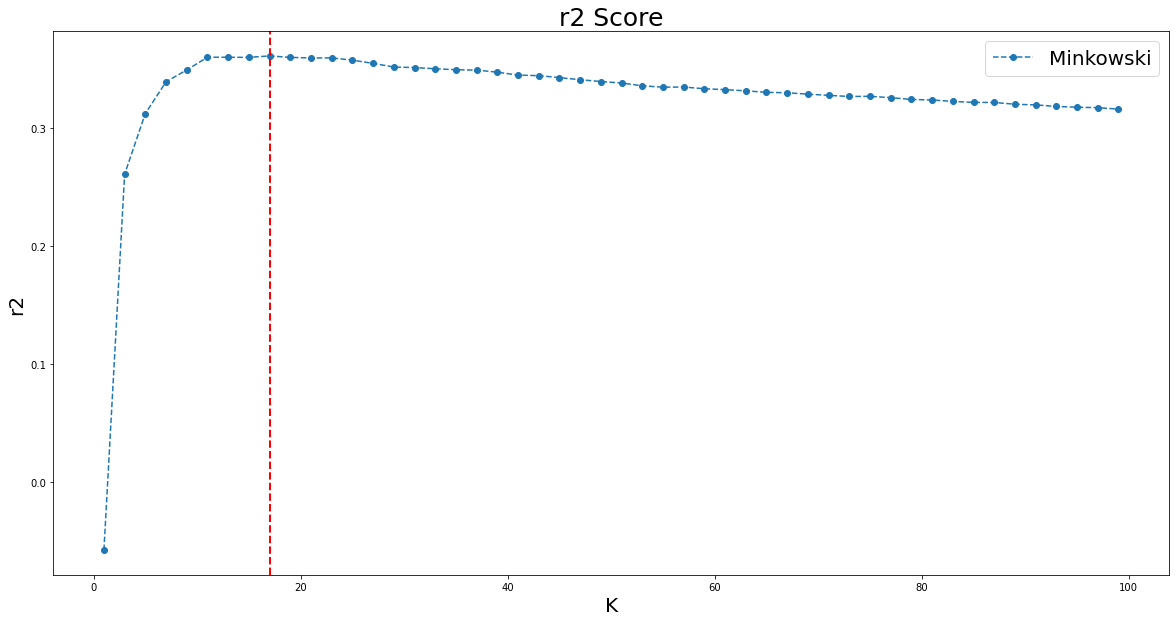

In [53]:
plt.figure(figsize=(20,10))
plt.plot(k_list, man, marker='o', linestyle='dashed')
plt.legend(['Minkowski'], fontsize=20)
plt.xlabel('K', fontsize=20)
plt.ylabel('r2', fontsize=20)
plt.title('r2 Score', fontsize=25)
plt.axvline(best_k_kow[0], color='r', linestyle='--', linewidth=2)
plt.show()

### 4.3 최종 모델 선정 및 성능 확인

**최종모델:** 유클리디언 거리 & k=17

In [44]:
reg = KNeighborsRegressor(n_neighbors=17, p=2)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

print(reg.score(X_test, y_test))

0.3837417505221826
